In [2]:
import pennylane as qml
import pennylane.numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import json

In [5]:
import vqd

In [6]:
d_observables = qml.data.Dataset()
d_observables.read('observable_results_v2.dat')

In [7]:
# only the n_qubits value actually matters here since we're not doing optimization
# but the VQD class takes them all during instantiation
total_time = 2.0
#total_time = 0.5
dt = 0.05
max_iterations = 500
cost_threshold = 0.0001
n_qubits = 3 # this needs to be 3, however!
interface = 'autograd'

In [11]:
#device_type = "qiskit.ibmq" # change this to run on real device
device_type = 'braket.aws.qubit'
s3 = ("amazon-braket-3fd3189a48a9", "simulator_runs")

In [12]:
backend="simulator"

# dev = ibm_device = qml.device(device_type, wires=n_qubits, backend=backend, 
#                               hub='qhack-event', group='main', project='level-1',
#                  ibmqx_token='') #insert token string!!

# dev = ibm_device = qml.device(device_type, wires=n_qubits, backend=backend, 
#                  ibmqx_token='') #insert token string!!

dev = qml.device(device_type, wires=n_qubits, 
                 device_arn="arn:aws:braket:::device/quantum-simulator/amazon/sv1", 
                 s3_destination_folder=s3)

In [14]:
shots = 80 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[shots]

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = dev)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results_v2.dat')

time :0.0
circuit params
[ 4.74236727e-02  4.73795575e-02  4.74236727e-02  8.12588205e-05
  8.12588205e-05  1.17739999e-03  2.35406511e-03  1.17739999e-03
 -2.99163400e-07 -2.99163400e-07  4.74236527e-02  4.73794787e-02
  4.74236527e-02  8.18083323e-05  8.18083323e-05  1.17819487e-03
  2.35565440e-03  1.17819487e-03]
running circuits

time :0.05
circuit params
[0.09493484 0.09472638 0.09493484 0.00054988 0.00054988 0.00338896
 0.00677182 0.00338896 0.00014685 0.00014685 0.09493423 0.09472403
 0.09493423 0.00071197 0.00071197 0.00340134 0.00679651 0.00340134]
running circuits

time :0.1
circuit params
[0.14238582 0.14183568 0.14238582 0.00163877 0.00163877 0.00644222
 0.01286233 0.00644222 0.00054464 0.00054464 0.14238173 0.14182029
 0.14238173 0.00226812 0.00226812 0.00650207 0.01298108 0.00650207]
running circuits

time :0.15000000000000002
circuit params
[0.18988607 0.18878113 0.18988607 0.00348369 0.00348369 0.01010032
 0.02014606 0.01010032 0.00123381 0.00123381 0.18987072 0.188725

In [15]:
def get_total_mag(results, shots):
    sig_x = np.tensor(results['observables'])[:,:3]
    sig_z = np.tensor(results['observables'])[:,3:]
    std_sig_x = np.sqrt(np.tensor(results['variances'])[:,:3]/shots)
    std_sig_z = np.sqrt(np.tensor(results['variances'])[:,3:]/shots)

    sum_sig_x = np.sum(sig_x, axis=1)
    sum_sig_z = np.sum(sig_z, axis=1)
    sum_sig_x_std = np.sqrt(np.sum(std_sig_x**2, axis=1))
    sum_sig_z_std = np.sqrt(np.sum(std_sig_z**2, axis=1))
    
    return sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std

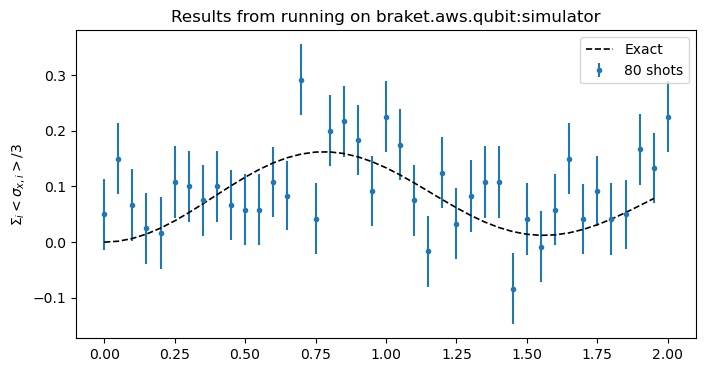

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_x/3, sum_sig_x_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{x,i}>/3$')
    
exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sx'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.set_title(f'Results from running on {device_type}:{backend}')
ax.legend()


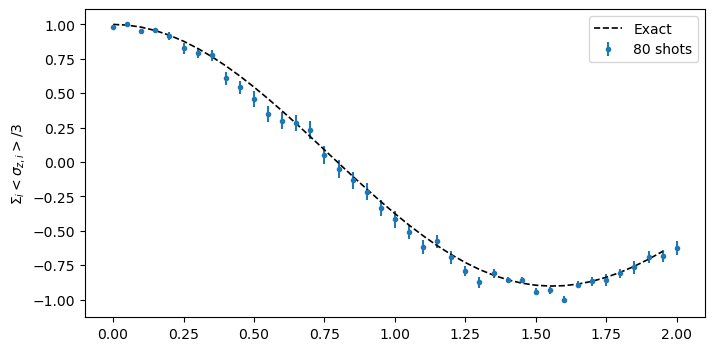

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_z/3, sum_sig_z_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{z,i}>/3$')

exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sz'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.legend()

In [19]:
shots = 800 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[shots]    #this is a hack

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = dev)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results_v2.dat')

time :0.0
circuit params
[ 4.74236727e-02  4.73795575e-02  4.74236727e-02  8.12588205e-05
  8.12588205e-05  1.17739999e-03  2.35406511e-03  1.17739999e-03
 -2.99163400e-07 -2.99163400e-07  4.74236527e-02  4.73794787e-02
  4.74236527e-02  8.18083323e-05  8.18083323e-05  1.17819487e-03
  2.35565440e-03  1.17819487e-03]
running circuits

time :0.05
circuit params
[0.09493484 0.09472638 0.09493484 0.00054988 0.00054988 0.00338896
 0.00677182 0.00338896 0.00014685 0.00014685 0.09493423 0.09472403
 0.09493423 0.00071197 0.00071197 0.00340134 0.00679651 0.00340134]
running circuits

time :0.1
circuit params
[0.14238582 0.14183568 0.14238582 0.00163877 0.00163877 0.00644222
 0.01286233 0.00644222 0.00054464 0.00054464 0.14238173 0.14182029
 0.14238173 0.00226812 0.00226812 0.00650207 0.01298108 0.00650207]
running circuits

time :0.15000000000000002
circuit params
[0.18988607 0.18878113 0.18988607 0.00348369 0.00348369 0.01010032
 0.02014606 0.01010032 0.00123381 0.00123381 0.18987072 0.188725

In [21]:
shots = 8000 # Change this value

# extract optimized circuit parameters from simulations
results = d_observables.observable_results[shots]

# create data storage structures
observable_results = {}
observables = []
variances = []
time_vals = []
observable_results[shots] = {}

# use the VQD class
vqdrunner = vqd.VQD(interface, 
                        total_time, 
                        dt, 
                        max_iterations, 
                        cost_threshold, 
                        n_qubits, 
                        shots=shots, 
                        optimization_step_size=0.05,
                        predefined_observable_device = dev)

# loop through time steps to run circuit with parameters
for a_time, params in zip(results['time'], results['final_params_v_time']):
    print(f"time :{a_time}")
    print("circuit params")
    print(params)
    
    time_vals.append(a_time)
    print('running circuits')
    observables.append(vqdrunner.qnode_three_spins_observables(params, shots=shots))
    variances.append(vqdrunner.qnode_three_spins_observables_variance(params, shots=shots))
    print('')
    
observable_results[shots]['observables'] = observables
observable_results[shots]['variances'] = variances
observable_results[shots]['time'] = time_vals
    
d_observables_on_device = qml.data.Dataset(on_device_observable_results = observable_results)
d_observables_on_device.write(f'{device_type}_{backend}_shots{shots}_observable_results_v2.dat')

time :0.0
circuit params
[ 4.74236727e-02  4.73795575e-02  4.74236727e-02  8.12588205e-05
  8.12588205e-05  1.17739999e-03  2.35406511e-03  1.17739999e-03
 -2.99163400e-07 -2.99163400e-07  4.74236527e-02  4.73794787e-02
  4.74236527e-02  8.18083323e-05  8.18083323e-05  1.17819487e-03
  2.35565440e-03  1.17819487e-03]
running circuits

time :0.05
circuit params
[0.09493484 0.09472638 0.09493484 0.00054988 0.00054988 0.00338896
 0.00677182 0.00338896 0.00014685 0.00014685 0.09493423 0.09472403
 0.09493423 0.00071197 0.00071197 0.00340134 0.00679651 0.00340134]
running circuits

time :0.1
circuit params
[0.14238582 0.14183568 0.14238582 0.00163877 0.00163877 0.00644222
 0.01286233 0.00644222 0.00054464 0.00054464 0.14238173 0.14182029
 0.14238173 0.00226812 0.00226812 0.00650207 0.01298108 0.00650207]
running circuits

time :0.15000000000000002
circuit params
[0.18988607 0.18878113 0.18988607 0.00348369 0.00348369 0.01010032
 0.02014606 0.01010032 0.00123381 0.00123381 0.18987072 0.188725

In [ ]:
# plotting tools

In [ ]:
def get_total_mag(results, shots):
    sig_x = np.tensor(results['observables'])[:,:3]
    sig_z = np.tensor(results['observables'])[:,3:]
    std_sig_x = np.sqrt(np.tensor(results['variances'])[:,:3]/shots)
    std_sig_z = np.sqrt(np.tensor(results['variances'])[:,3:]/shots)

    sum_sig_x = np.sum(sig_x, axis=1)
    sum_sig_z = np.sum(sig_z, axis=1)
    sum_sig_x_std = np.sqrt(np.sum(std_sig_x**2, axis=1))
    sum_sig_z_std = np.sqrt(np.sum(std_sig_z**2, axis=1))
    
    return sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_x/3, sum_sig_x_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{x,i}>/3$')
    
exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sx'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.set_title(f'Results from running on {device_type}:{backend}')
ax.legend()


In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
for s, results in observable_results.items():
    sum_sig_x, sum_sig_z, sum_sig_x_std, sum_sig_z_std = get_total_mag(results, s)
    ax.errorbar(results['time'],sum_sig_z/3, sum_sig_z_std/3, fmt = '.', label=f'{s} shots')
    ax.set_ylabel('$\Sigma_i <\sigma_{z,i}>/3$')

exact = json.load(open('exact_solutions.dat'))
ax.plot(exact['times'][:40],exact['Sz'][:40],label ="Exact",linestyle='dashed',linewidth=1.2,color='black')
ax.legend()